# Grokking with a simple model on modular addition

## 0. Preliminaries

Imports and set the CUDA device

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA       # Needed for PCA of embeddings
import os

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

Using GPU NVIDIA RTX A4500


Set seed everywhere for reproducibility

In [2]:
SEED = 42

def set_seed(seed_value=0):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## 1. Building the dataset
Define the dataset : addition modulo P, with a random split into train and test sets, and dataloaders with batch size

In [3]:
# Prime number for modular addition
P = 53

# Create the dataset
set_seed(SEED)
data = []
for i in range(P):
    for j in range(P):
        data.append([i,j,(i+j)%P])
data = np.array(data)

# Split into train and test
TRAIN_FRACTION = 0.5
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
BATCH_SIZE = 64
train_data = torch.tensor(train_data, dtype=torch.long, device=device)
test_data = torch.tensor(test_data, dtype=torch.long, device=device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 2. Model definition
A linear embedding layer followed by concatenation of the two (embedded) tokens, and a simple FF with one hidden layer.

In [4]:
D_EMBED = 128
HIDDEN = 256

class EmbeddingConcatFFModel(nn.Module):
    def __init__(self):
        super(EmbeddingConcatFFModel, self).__init__()
        self.embed = nn.Embedding(P, D_EMBED)
        self.linear1 = nn.Linear(2 * D_EMBED, HIDDEN)   # 2 * D_EMBED because we concatenate the two embedded tokens
        self.linear2 = nn.Linear(HIDDEN, P)
        self.init_weights()
        
    def forward(self, x1, x2):
        x1 = self.embed(x1)
        x2 = self.embed(x2)
        x = torch.cat((x1, x2), dim=1)  # Concatenate the embedding of the two tokens
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
    # Weight initialization
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)               
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

## 3. Training
We use AdamW with weight decay, and cross entropy loss

In [5]:
NB_EPOCHS = 20000
LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1

set_seed(SEED)
model = EmbeddingConcatFFModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Recording
REPORT_INTERVAL = 20    # How often we print
SAVE_INTERVAL = 50      # How often we save
model_folder = 'intermediary'
# Create folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_loader:
        x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
        optimizer.zero_grad()
        output = model(x1,x2)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
        
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for batch in test_loader:
            x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
            output = model(x1,x2)
            loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        
    if epoch % REPORT_INTERVAL == 0:
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")
    
    if epoch % SAVE_INTERVAL == 0:
        # Save model in intermediary folder
        torch.save(model.state_dict(), f"{model_folder}/model_{epoch}.pth")
        
torch.save(model.state_dict(), f"model.pth")

0/20000: Train loss=3.9842, acc=1.4%  /  Test loss=3.9773, acc=1.8%
20/20000: Train loss=3.7724, acc=15.7%  /  Test loss=4.1312, acc=0.0%
40/20000: Train loss=3.4619, acc=22.8%  /  Test loss=4.4669, acc=0.0%
60/20000: Train loss=3.0404, acc=36.0%  /  Test loss=5.0253, acc=0.0%
80/20000: Train loss=2.6496, acc=51.9%  /  Test loss=5.5697, acc=0.0%
100/20000: Train loss=2.3173, acc=70.1%  /  Test loss=5.9904, acc=0.0%
120/20000: Train loss=2.0313, acc=84.8%  /  Test loss=6.3001, acc=0.0%
140/20000: Train loss=1.7855, acc=93.3%  /  Test loss=6.5174, acc=0.0%
160/20000: Train loss=1.5720, acc=97.7%  /  Test loss=6.6685, acc=0.0%
180/20000: Train loss=1.3897, acc=99.2%  /  Test loss=6.7627, acc=0.0%
200/20000: Train loss=1.2310, acc=99.6%  /  Test loss=6.8105, acc=0.0%
220/20000: Train loss=1.0938, acc=99.9%  /  Test loss=6.8261, acc=0.0%
240/20000: Train loss=0.9738, acc=100.0%  /  Test loss=6.8100, acc=0.0%
260/20000: Train loss=0.8690, acc=100.0%  /  Test loss=6.7719, acc=0.0%
280/20000: 

## 4. Results

Plot the evolution of accuracy and loss during training

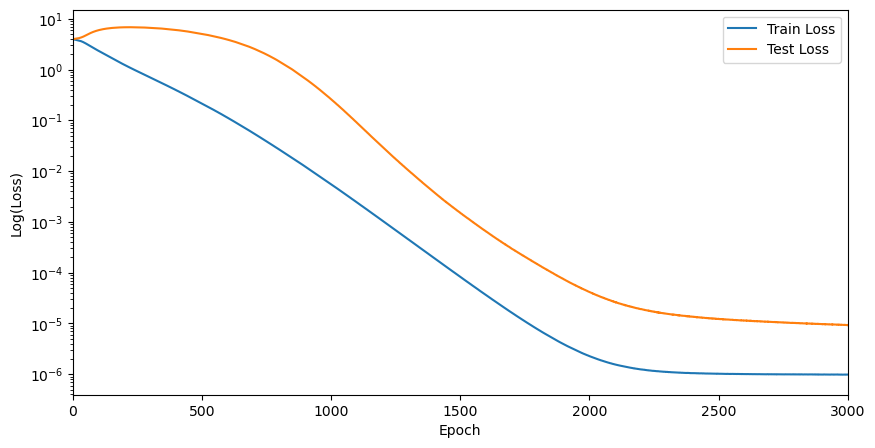

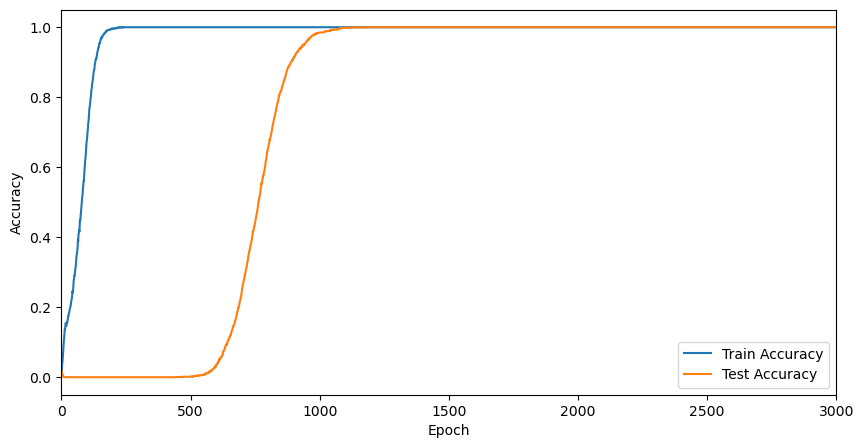

In [6]:
NB_EPOCH_PLOT = 3000

# Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, NB_EPOCHS + 1), test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.yscale('log')
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('loss_zoom.png', dpi=300)


# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NB_EPOCHS + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, NB_EPOCHS + 1), test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png', dpi=300)
plt.xlim(0,NB_EPOCH_PLOT)
plt.savefig('accuracy_zoom.png', dpi=300)

### Principal Component Analysis of the embeddings

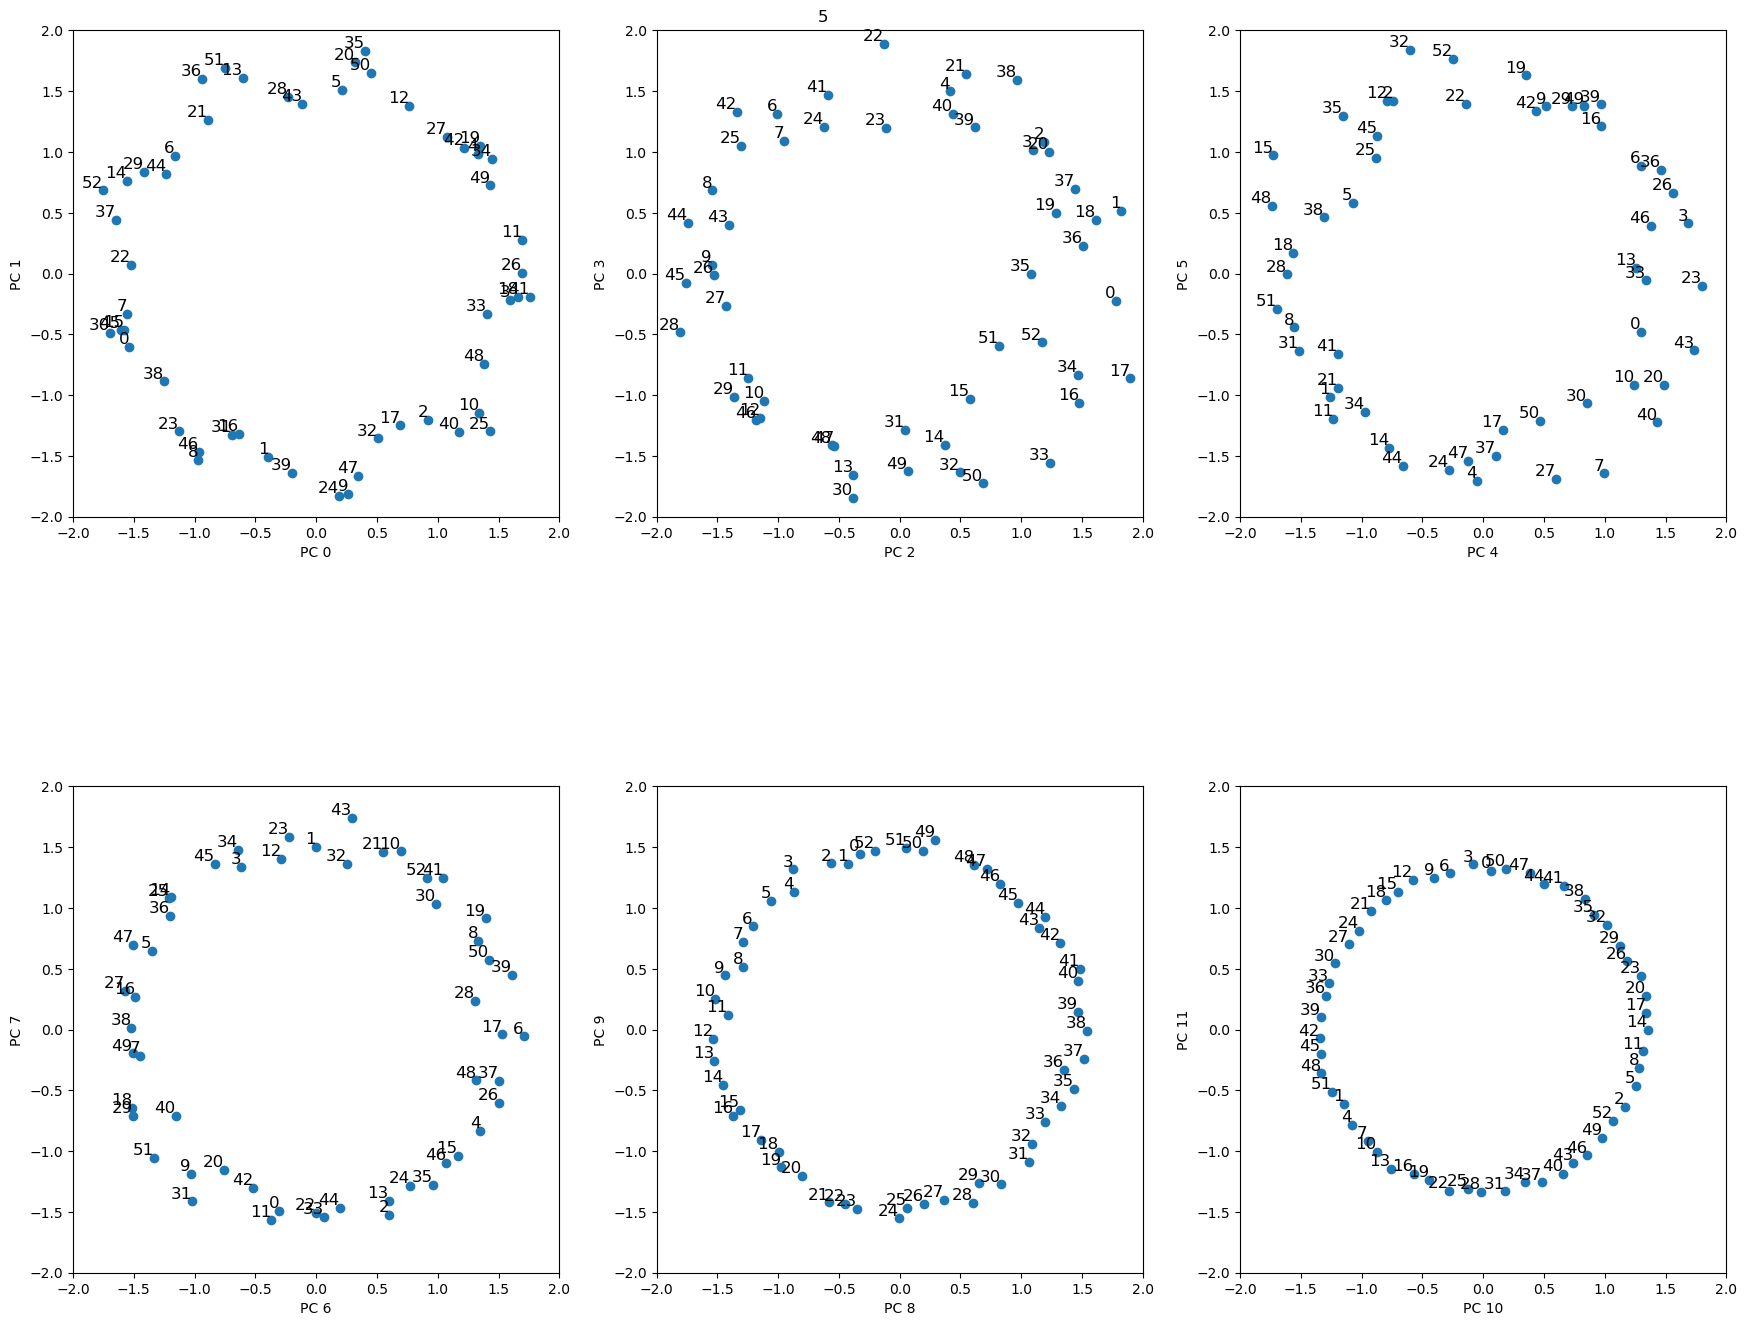

In [7]:
# Extract embeddings
model.load_state_dict(torch.load(f"model.pth"))
model.eval()
with torch.no_grad():
    embeddings = model.embed(torch.arange(0, P).to(device)).cpu().numpy()

# PCA
NB_COMPONENTS = 12
pca = PCA(n_components=NB_COMPONENTS)
embeddings_pca = pca.fit_transform(embeddings)

# Plot
ny = int(np.floor(np.sqrt(16/9 * NB_COMPONENTS // 2)))
nx = int(np.ceil((NB_COMPONENTS //2) / ny))

plt.figure(figsize=(16/9 * 6 * nx, 6 * ny))
for n in range(NB_COMPONENTS // 2):
    plt.subplot(nx, ny, n + 1)
    plt.scatter(embeddings_pca[:, 2 * n + 0], embeddings_pca[:, 2 * n + 1], marker='o')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.gca().set_aspect('equal')

    # Annotate each point on the scatter plot
    for i, (x, y) in enumerate(embeddings_pca[:, (2 * n + 0):(2 * n + 2)]):
        plt.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        
    plt.xlabel(f"PC {2 * n + 0}")
    plt.ylabel(f"PC {2 * n + 1}")

plt.savefig('pca.png', dpi=300)

Follow the evolution of the embeddings during training projected on the principal components found before

0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
101

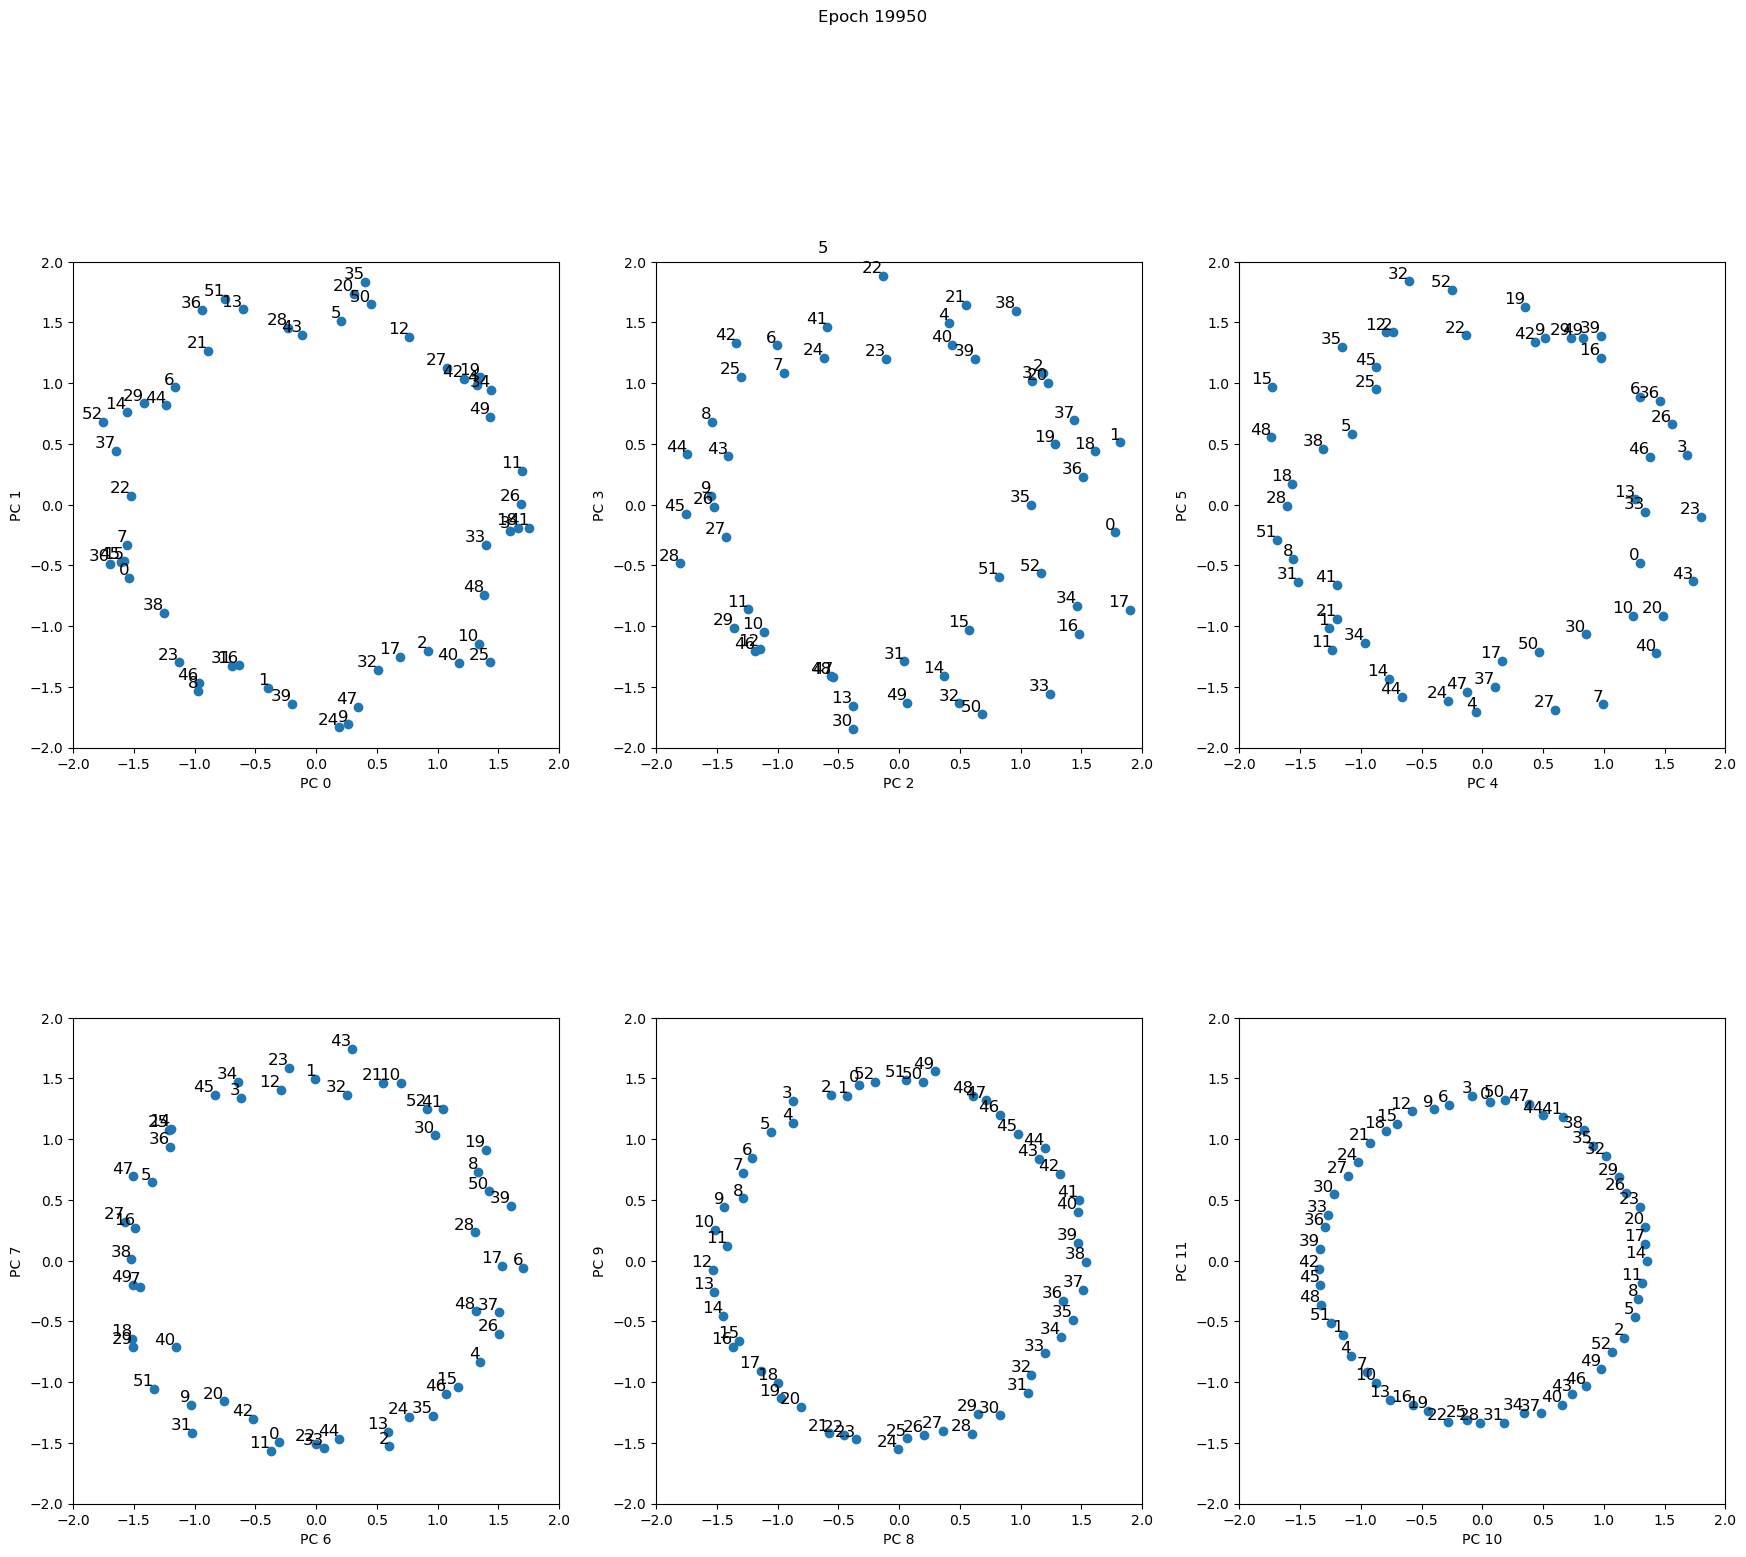

In [8]:
from matplotlib.animation import FuncAnimation

# Plot
ny = int(np.floor(np.sqrt(16/9 * NB_COMPONENTS // 2)))
nx = int(np.ceil((NB_COMPONENTS //2) / ny))

fig, axes = plt.subplots(nx, ny, figsize=(16/9 * 6 * nx, 6 * ny))

def update(epoch):
    print(epoch)
    model.load_state_dict(torch.load(f"{model_folder}/model_{epoch}.pth"))
    model.eval()
    with torch.no_grad():
        embeddings = model.embed(torch.arange(0, P).to(device)).cpu().numpy()
    embeddings_pca = pca.transform(embeddings)

    for n, ax in enumerate(axes.flatten()):
        ax.clear()
        ax.scatter(embeddings_pca[:, 2 * n], embeddings_pca[:, 2 * n + 1], marker='o')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_aspect('equal')

        for i, (x, y) in enumerate(embeddings_pca[:, (2 * n):(2 * n + 2)]):
            ax.text(x, y, str(i), fontsize=12, ha='right', va='bottom')
        
        ax.set_xlabel(f"PC {2 * n}")
        ax.set_ylabel(f"PC {2 * n + 1}")

    plt.suptitle(f"Epoch {epoch}")

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, NB_EPOCHS, SAVE_INTERVAL), blit=False)

# Save animation
ani.save('pca_evolution.mp4', writer='ffmpeg')

plt.show()